In [7]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit


In [8]:
def read_wave(file_path):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=np.int32)  # Assuming 32-bit WAV files
        signal = signal/np.max(np.abs(signal))
        signal = abs(signal)

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=len(signal))
        

    return signal, sample_rate, time

@numba.njit(fastmath=True)
def peak_finder_neigh(t_list, y_list, neigh=2, threshold=0.1):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1] and y_list[i] > threshold:

            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(t_peak), np.array(peaks)

@numba.njit(fastmath=True)
def signal_avg(signal, time, step):
    new_signal = []
    new_time = time[::step] 

    i = 0
    while i < len(signal):
        if i+10 < len(signal):
            new_signal.append(np.mean(signal[i:i+step]))
            i += step
        else:
            new_signal.append(np.mean(signal[i:]))
            i += step

    return new_time, new_signal

@numba.njit(fastmath=True)
def lin_fit(x, a, b):
    return a*x + b

def data_extract(file, step=200, neigh=10, threshold=0.1):
    signal, sample_rate, time = read_wave(file)
    time, signal = signal_avg(signal, time, step)
    peak_times, peaks = peak_finder_neigh(time, signal, neigh, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[:-1]

    return time, signal, peak_times, peaks, freq_tlist, freq_list

@numba.njit(fastmath=True)
def p_func(x_list, threshold_l, threshold_h):

    p = np.zeros(len(x_list))

    for i in range(len(x_list)): 
        if x_list[i] <= threshold_l:
            p[i] = 1
        elif x_list[i] > threshold_l and x_list[i] <= threshold_h:
            p[i] = 1/2 * (1 + np.cos(np.pi * (x_list[i] - threshold_l) / (threshold_h - threshold_l + 1)))
        else:
            p[i] = 0 
        
    return p


@numba.njit(fastmath=True)
def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i

@numba.njit(fastmath=True)
def synchro(cut, ft_list_exp, f_list_exp, ft_list_met, f_list_met):
    ### THIS ASSUMES THAT PARTICIPANTS CLAP AT THE FIRST BEEP OF THE METRONOME ### 

    min_val = min(f_list_met)
    min_index = np.where(f_list_met == min_val)[0][0]


    # Cutting off the beep sound at the start
    f_list_met = f_list_met[min_index+1:]
    ft_list_met = ft_list_met[min_index+1:]

    # Cutting off a desired number of claps
    ft_list_exp = ft_list_exp[cut:]
    f_list_exp = f_list_exp[cut:]
    ft_list_met = ft_list_met[cut:]
    f_list_met = f_list_met[cut:]

    # Synchronizing the two signals at the first data point
    diff = ft_list_exp[0] - ft_list_met[0]
    ft_list_exp = ft_list_exp - diff

    return ft_list_exp, f_list_exp, ft_list_met, f_list_met

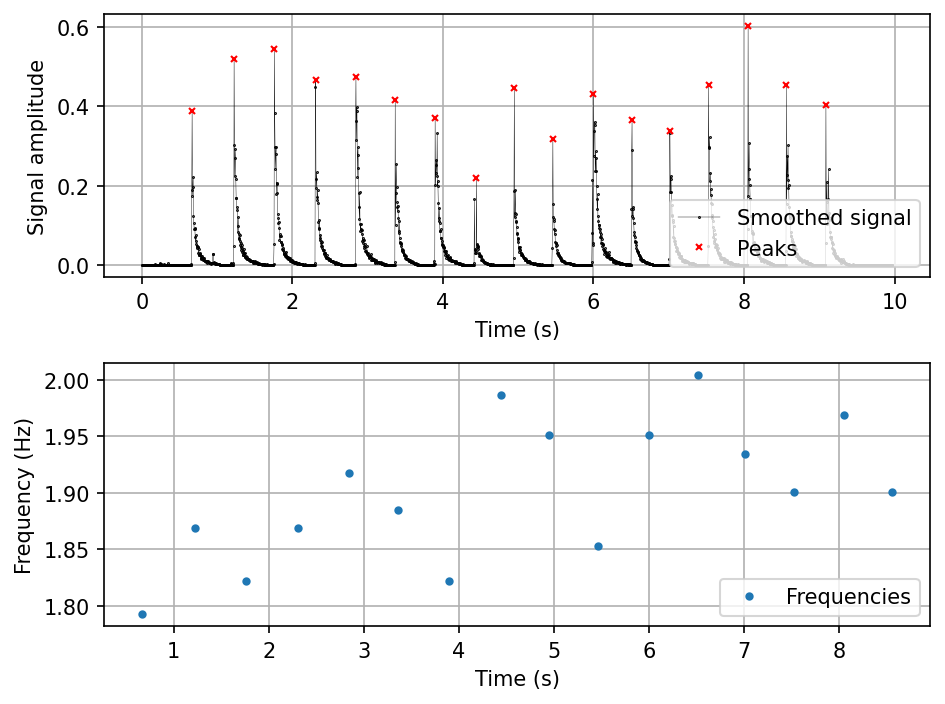

In [9]:
new_time, new_signal, peak_times, peaks, freq_tlist, freq_list = data_extract('trial.wav', step=200, neigh=10, threshold=0.1)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time, new_signal, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(peak_times, peaks, color='red', ls='', marker='x', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')

ax[1].plot(freq_tlist, freq_list, '.', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

In [10]:
new_time_ns, new_signal_ns, peak_times_ns, peaks_ns, freq_tlist_ns, freq_list_ns = data_extract('lydfiler/metronomfiler/Niels_og_Sigrid.wav', step=200, neigh=10, threshold=0.03)
lm_t, lm_s, lm_pt, lm_p, lm_ft, lm_fl = data_extract('lydfiler/metronomfiler/low_mid.wav', step=200, neigh=15, threshold=0.1)

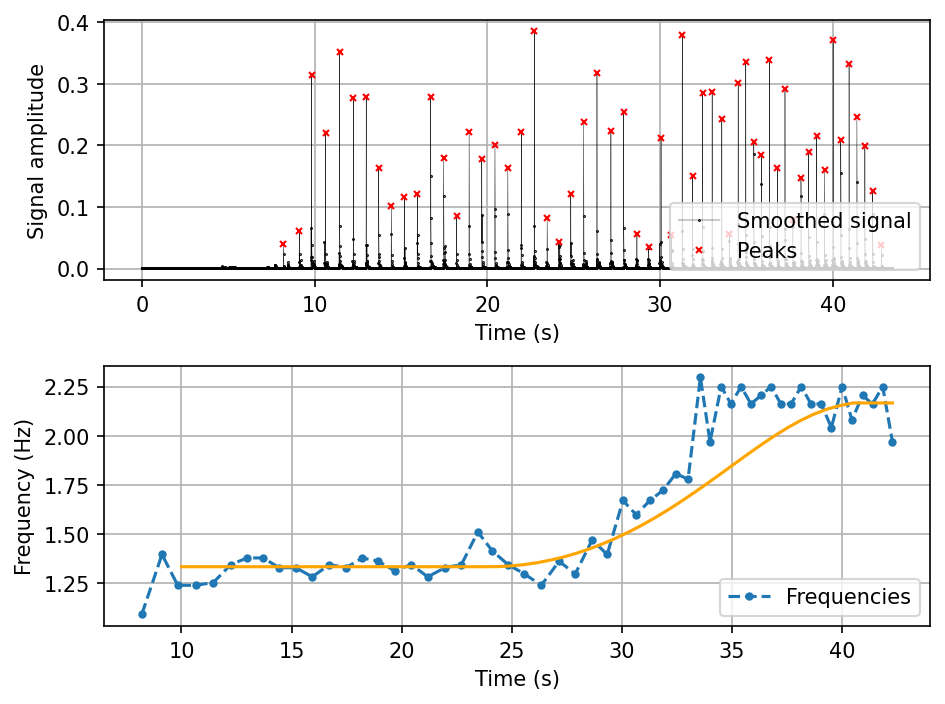

In [11]:
sig_x = np.linspace(10, freq_tlist_ns[-1], len(freq_tlist_ns))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)


fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time_ns, new_signal_ns, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(peak_times_ns, peaks_ns, color='red', ls='', marker='x', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')

ax[1].plot(freq_tlist_ns, freq_list_ns, '.--', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')
ax[1].plot(sig_x, sig_y, c='orange')

fig.tight_layout()

In [12]:
cut = 7
freq_tlist_ns, freq_list_ns, lm_ft, lm_fl = synchro(cut, freq_tlist_ns, freq_list_ns, lm_ft, lm_fl)


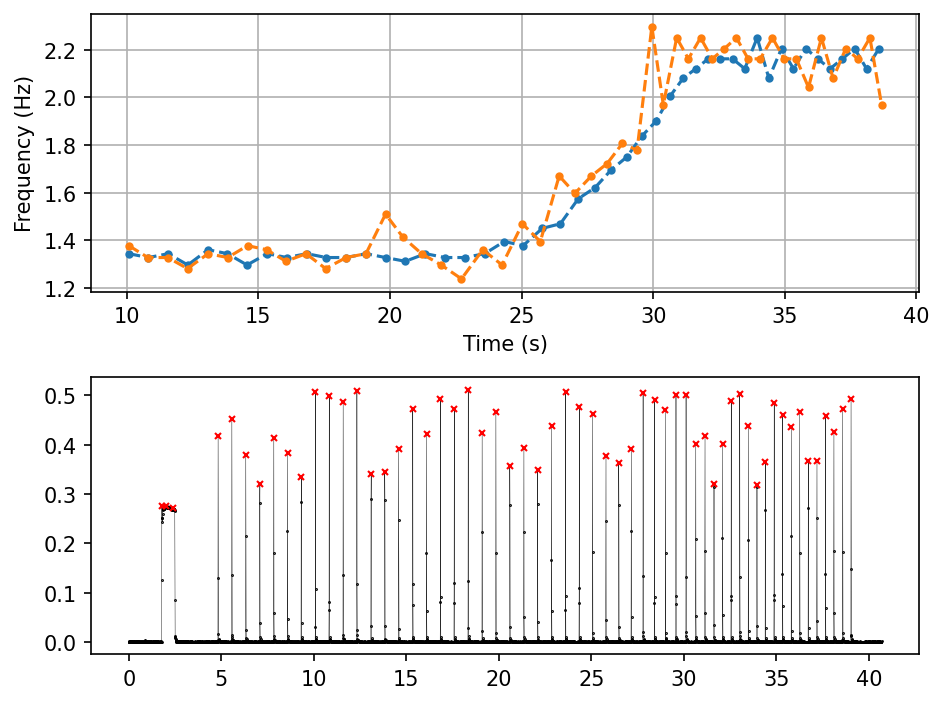

In [13]:

fig, ax = plt.subplots(2,1, dpi=150)

ax[0].plot(lm_ft, lm_fl, '.--', label='Metronome frequencies')
ax[0].plot(freq_tlist_ns, freq_list_ns, '.--', label='Experiment frequencies')

ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)')

ax[1].plot(lm_t, lm_s, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[1].plot(lm_pt, lm_p, color='red', ls='', marker='x', markersize=3, label='Peaks')

fig.tight_layout()